In [6]:
from rdkit import Chem
from copy import deepcopy

def calculate_chemical_properties(dictionary_list):
    updated_list = deepcopy(dictionary_list)  # Create a deep copy of the original list
    for entry in updated_list:
        reactant_smiles = entry['reactants']
        product_smiles = entry['products']

        # Process for carbon difference calculation
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        product_mol = Chem.MolFromSmiles(product_smiles)

        if reactant_mol is not None and product_mol is not None:
            num_carbon_reactants = reactant_mol.GetNumAtoms(6)
            num_carbon_products = product_mol.GetNumAtoms(6)
            delta = abs(num_carbon_reactants - num_carbon_products)
            entry['carbon_difference'] = delta
        else:
            entry['carbon_difference'] = "Invalid SMILES"

        # Process for fragment count calculation
        reactant_fragment_count = len(reactant_smiles.split('.'))
        product_fragment_count = len(product_smiles.split('.'))
        total_fragment_count = reactant_fragment_count + product_fragment_count
        entry['fragment_count'] = total_fragment_count

    return updated_list

In [49]:
import sys
sys.path.append('../../../')
from SynRBL.rsmi_utils import load_database
import re
from rdkit import Chem


def remove_atom_mapping_from_reaction_smiles(reaction_smiles):
    """
    Remove atom mapping from a reaction SMILES string.
    
    Parameters:
    - reaction_smiles (str): A reaction SMILES string with atom mapping.
    
    Returns:
    - str: A reaction SMILES string without atom mapping.
    """
    # Split the reaction SMILES into its components (reactants, agents, products)
    parts = reaction_smiles.split('>>')
    
    # Remove atom mapping from each part
    cleaned_parts = [Chem.CanonSmiles(re.sub(r":\d+", "", part)) for part in parts]
    
    # Concatenate the cleaned parts back into a reaction SMILES string
    cleaned_reaction_smiles = '>>'.join(cleaned_parts)
    
    return cleaned_reaction_smiles



TEST

In [15]:
import pandas as pd
from SynRBL.rsmi_utils import load_database
from IPython.display import clear_output

data_name = 'golden_dataset'
data = pd.read_csv(f'../../../Pipeline/Validation/Analysis/SynRBL - {data_name}.csv').drop(['Note'], axis=1)
data.loc[data['Result'] == 'CONSIDER', 'Result']='FALSE'

merge_data = load_database(f'../../../Data/Validation_set/{data_name}/MCS/MCS_Impute.json.gz')
mcs_data = load_database(f'../../../Data/Validation_set/{data_name}/mcs_based_reactions.json.gz')
mcs_data = calculate_chemical_properties(mcs_data)
clear_output(wait=False)
mcs_data[0]

{'reactions': '[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=[CH2:8].[NH2:11][CH:10]([CH3:9])[CH:12]([OH:13])[CH:14]=[CH2:15]>>[CH:14](=[CH:7][CH2:6][S:5][CH2:4][C:2]([CH3:1])=[O:3])[CH:12]([OH:13])[CH:10]([NH2:11])[CH3:9]',
 'id': 'golden_1',
 'reactants': '[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=[CH2:8].[NH2:11][CH:10]([CH3:9])[CH:12]([OH:13])[CH:14]=[CH2:15]',
 'products': '[CH:14](=[CH:7][CH2:6][S:5][CH2:4][C:2]([CH3:1])=[O:3])[CH:12]([OH:13])[CH:10]([NH2:11])[CH3:9]',
 'R-id': 'golden_dataset_1',
 'carbon_balance_check': 'products',
 'carbon_difference': 2,
 'fragment_count': 3}

In [ ]:
data2=pd.concat([pd.DataFrame(mcs_data)[['R-id','carbon_difference', 'fragment_count']],data, pd.DataFrame(merge_data)[['mcs_carbon_balanced']]], axis=1)
data2 = data2[data2['mcs_carbon_balanced'] == True]

In [83]:
import pandas as pd

def process_and_combine_datasets(list_data, pipeline_path, data_path):
    """
    Processes and combines datasets from specified paths.

    Parameters:
    - list_data (list): List of dataset names.
    - pipeline_path (str): Path to the pipeline files.
    - data_path (str): Path to the data files.

    Returns:
    - pd.DataFrame: Combined DataFrame of all processed datasets.
    """
    data_all = pd.DataFrame()
    
    for data_name in list_data:
        # Load dataset CSV and adjust columns
        data_csv_path = f'{pipeline_path}/Validation/Analysis/SynRBL - {data_name}.csv'
        data = pd.read_csv(data_csv_path).drop(['Note'], axis=1)
        data.loc[data['Result'] == 'CONSIDER', 'Result'] = 'FALSE'
        
        # Load and process additional data
        merge_data_path = f'{data_path}/Validation_set/{data_name}/MCS/MCS_Impute.json.gz'
        mcs_data_path = f'{data_path}/Validation_set/{data_name}/mcs_based_reactions.json.gz'
        
        merge_data = load_database(merge_data_path)
        mcs_data = load_database(mcs_data_path)
        mcs_data = calculate_chemical_properties(mcs_data)
        clear_output(wait=False)
        
        # Combine data
        combined_data = pd.concat([
            pd.DataFrame(mcs_data)[['R-id', 'reactions', 'carbon_difference', 'fragment_count']],
            data,
            pd.DataFrame(merge_data)[['mcs_carbon_balanced']]
        ], axis=1)
        
        combined_data = combined_data[combined_data['mcs_carbon_balanced'] == True]
        
        data_all = pd.concat([data_all, combined_data], axis=0)
    data_all = data_all.reset_index(drop=True)
    data_all = data_all[['R-id', 'reactions', 'carbon_difference', 'fragment_count',
       'Result', 'Bond Changes',
       'mcs_carbon_balanced']]
    return data_all

# Example usage
list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_unbalance_class', 'USPTO_diff']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'

# Assuming load_database and calculate_chemical_properties are defined elsewhere
data_all = process_and_combine_datasets(list_data, pipeline_path, data_path)


In [84]:
data_all

,R-id,reactions,carbon_difference,fragment_count,Result,Bond Changes,mcs_carbon_balanced
0,golden_dataset_1,[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=...,2,3,FALSE,4.0,True
1,golden_dataset_2,[CH3:1][C:2]([CH3:3])([CH3:4])[Si:5]([CH3:6])(...,12,2,TRUE,2.0,True
2,golden_dataset_7,[CH3:28][Si:27]([CH3:29])([CH3:30])[CH2:26][CH...,2,2,TRUE,1.0,True
3,golden_dataset_10,[F:34][C:33]([F:35])([F:36])[C:31]([C:37]([F:4...,3,3,TRUE,1.0,True
4,golden_dataset_11,[CH2:7]([CH2:8][CH2:9][CH:10]=[CH2:11])[CH3:6]...,2,3,FALSE,4.0,True
...,...,...,...,...,...,...,...
2156,USPTO_diff_1624,CCC(=O)c1ccc2c(c1)ncn2C.O=C(c1ccc(O)cc1)c1ccc(...,2,3,True,4.0,True
2157,USPTO_diff_1625,Clc1ccc(C=C(Br)Br)c(Cl)c1>>C#Cc1ccc(Cl)cc1Cl,2,2,True,2.0,True
2158,USPTO_diff_1626,COC(=O)c1ccc(F)cc1Br.O=[N+]([O-])c1ccc(F)cc1Br...,2,3,True,2.0,True
2159,USPTO_diff_1627,CCC(C(N)=O)N1CC(C=C(Br)Br)CC1=O>>C#CC1CC(=O)N(...,2,2,True,2.0,True


In [85]:
def standardize_columns(data):
    data.loc[data['carbon_difference']>10, 'carbon_difference'] = 15
    data.loc[data['fragment_count']>10, 'fragment_count'] = 11
    data.loc[data['Bond Changes']>5, 'Bond Changes'] = 6
    data['reactions'] = data['reactions'].apply(lambda x: remove_atom_mapping_from_reaction_smiles(x))
    data = data.drop_duplicates(subset=['reactions'])
    data['Result'] = data['Result'].astype('bool')
    return data

In [86]:
data_all = standardize_columns(data_all)

data_all.shape

[09:57:25] WARNING: not removing hydrogen atom without neighbors
[09:57:25] WARNING: not removing hydrogen atom without neighbors
[09:57:25] WARNING: not removing hydrogen atom without neighbors
[09:57:25] WARNING: not removing hydrogen atom without neighbors
[09:57:25] WARNING: not removing hydrogen atom without neighbors
[09:57:25] WARNING: not removing hydrogen atom without neighbors
[09:57:25] WARNING: not removing hydrogen atom without neighbors
/tmp/ipykernel_194521/2821171265.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Result'] = data['Result'].astype('bool')


(1997, 7)

In [87]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, 0 to 2160
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   R-id                 1997 non-null   object 
 1   reactions            1997 non-null   object 
 2   carbon_difference    1997 non-null   int64  
 3   fragment_count       1997 non-null   int64  
 4   Result               1997 non-null   bool   
 5   Bond Changes         1997 non-null   float64
 6   mcs_carbon_balanced  1997 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 111.2+ KB


In [90]:
data_all['Result'].value_counts()

Result
True     1963
False      34
Name: count, dtype: int64

/tmp/ipykernel_194521/993677338.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_194521/993677338.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_194521/993677338.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_194521/993677338.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so result

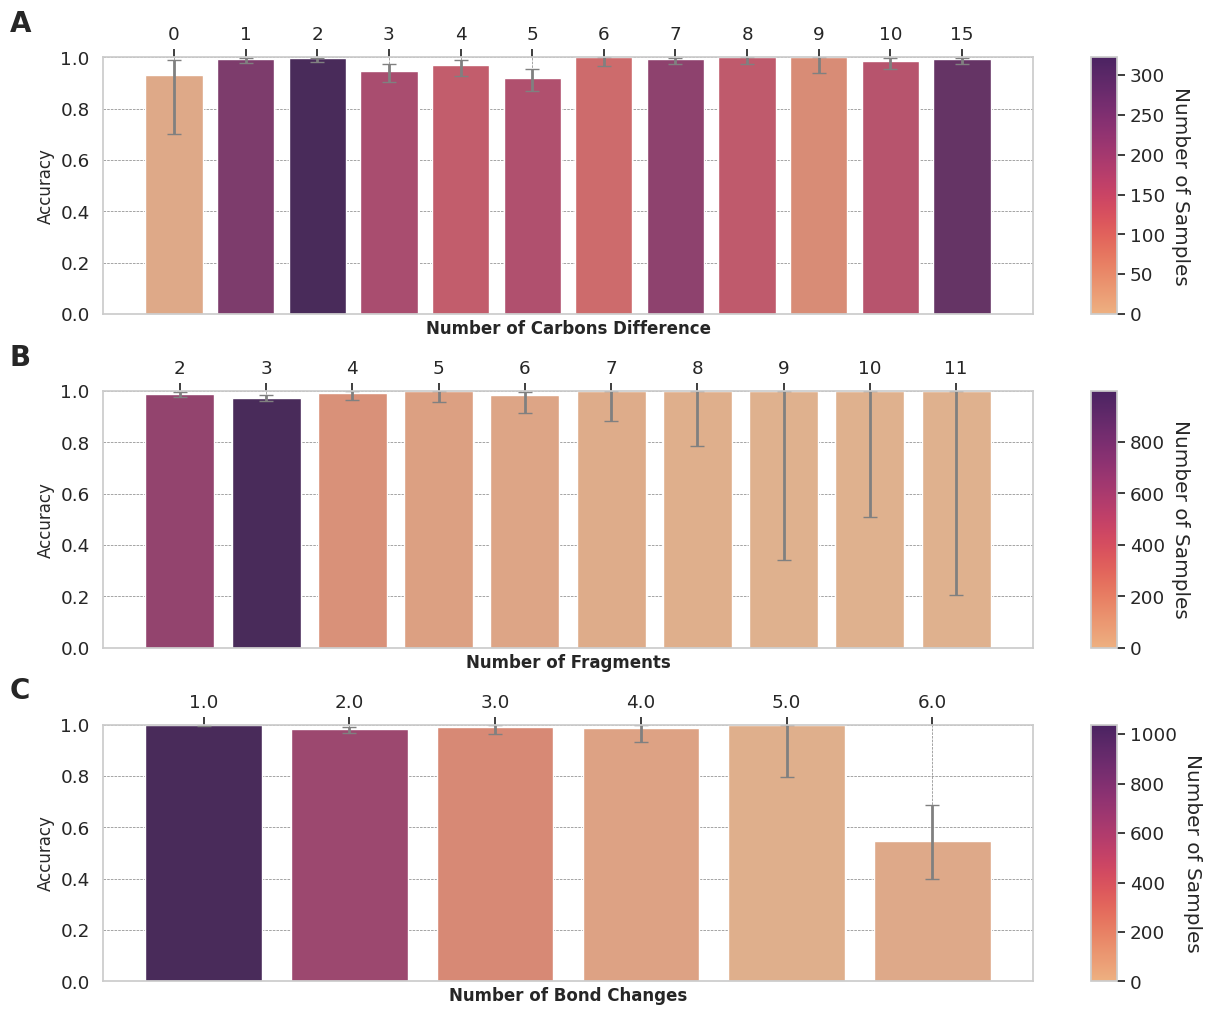

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def visualize_accuracy(df, error_bar=True, chart_type='line', error_bar_color='black', same_color_scale=False, show_values=False, savepath=None):
    def calculate_accuracy_and_confidence(df, column):
        group_data = df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        
        group_data = group_data[group_data['Accuracy'] > 0]  # Filter out groups with zero accuracy

        if error_bar:
            confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
            group_data['lower'] = group_data['Accuracy'] - confidence_lower
            group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    cmap = plt.get_cmap('flare', 256)

    # Calculate accuracy and confidence for each property
    accuracy_carbon = calculate_accuracy_and_confidence(df, 'carbon_difference')
    accuracy_fragment = calculate_accuracy_and_confidence(df, 'fragment_count')
    accuracy_bondchanges = calculate_accuracy_and_confidence(df, 'Bond Changes')

    # Determine the global maximum size for same color scale
    if same_color_scale:
        max_size = max(accuracy_carbon['size'].max(), accuracy_fragment['size'].max(), accuracy_bondchanges['size'].max())
        norm = plt.Normalize(vmin=0, vmax=max_size)
    else:
        norm = None

    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), gridspec_kw={'hspace': 0.3})

    def plot_data(data, x, y, lower, upper, size, subplot_index, xlabel, ecolor, norm, show_values):
        ax = axes[subplot_index]
        local_norm = norm if same_color_scale else plt.Normalize(vmin=0, vmax=data[size].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=local_norm)
        sm.set_array([])

        colors = [mcolors.to_rgba(cmap(local_norm(s))) for s in data[size]]

        if chart_type == 'line':
            sns.lineplot(data=data, x=x, y=y, marker='o', ax=ax, palette=colors)
            if error_bar:
                ax.errorbar(data[x], data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='o', capsize=5, ecolor=ecolor)
        elif chart_type == 'bar':
            barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
            ax.set_ylim(0, 1)
            if error_bar:
                x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]
                ax.errorbar(x_positions, data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='none', ecolor=ecolor, capsize=5, elinewidth=2)

            # Annotate bar values if show_values is True
            if show_values:
                for bar in barplot.patches:
                    ax.annotate(format(bar.get_height(), '.2f'),
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                ha='center', va='bottom',
                                xytext=(0, 5), textcoords='offset points')

        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
        ax.set_facecolor('white')
        cbar = plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05, aspect=10)
        cbar.ax.set_ylabel('Number of Samples', rotation=-90, va="bottom")

        ax.xaxis.set_label_position('bottom')
        ax.xaxis.tick_top()
        ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.text(-0.1, 1.1, chr(65 + subplot_index), transform=ax.transAxes, size=20, weight='bold')

    plot_data(accuracy_carbon, 'carbon_difference', 'Accuracy', 'lower', 'upper', 'size', 0, 'Number of Carbons Difference', error_bar_color, norm, show_values)
    plot_data(accuracy_fragment, 'fragment_count', 'Accuracy', 'lower', 'upper', 'size', 1, 'Number of Fragments', error_bar_color, norm, show_values)
    plot_data(accuracy_bondchanges, 'Bond Changes', 'Accuracy', 'lower', 'upper', 'size', 2, 'Number of Bond Changes', error_bar_color, norm, show_values)

    plt.tight_layout(pad=4.0)
    plt.savefig(savepath)
    plt.show()

# Example usage (assuming 'data3' is a suitable DataFrame)
visualize_accuracy(data_all, error_bar=True, chart_type='bar', error_bar_color='gray', same_color_scale=False, show_values=False, savepath = './mcs_all.pdf')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = [82.58, 82.64, 68.21, 91.86, 84.81]
accuracy = [99.73, 98.90, 99.38, 99.91, 99.58]

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 7))

# Using the "flare" colormap
cmap = plt.get_cmap('flare')
color_for_success_rate = cmap(0.3)  # A specific color from the "flare" colormap for Success Rate
color_for_accuracy = cmap(0.7)  # A different specific color from the "flare" colormap for Accuracy

bars1 = ax.bar(index - bar_width/2, success_rate, bar_width, label='Success Rate', color=color_for_success_rate)
bars2 = ax.bar(index + bar_width/2, accuracy, bar_width, label='Accuracy', color=color_for_accuracy)

#plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 120)

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.savefig('rule_based.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


In [ ]:
data3

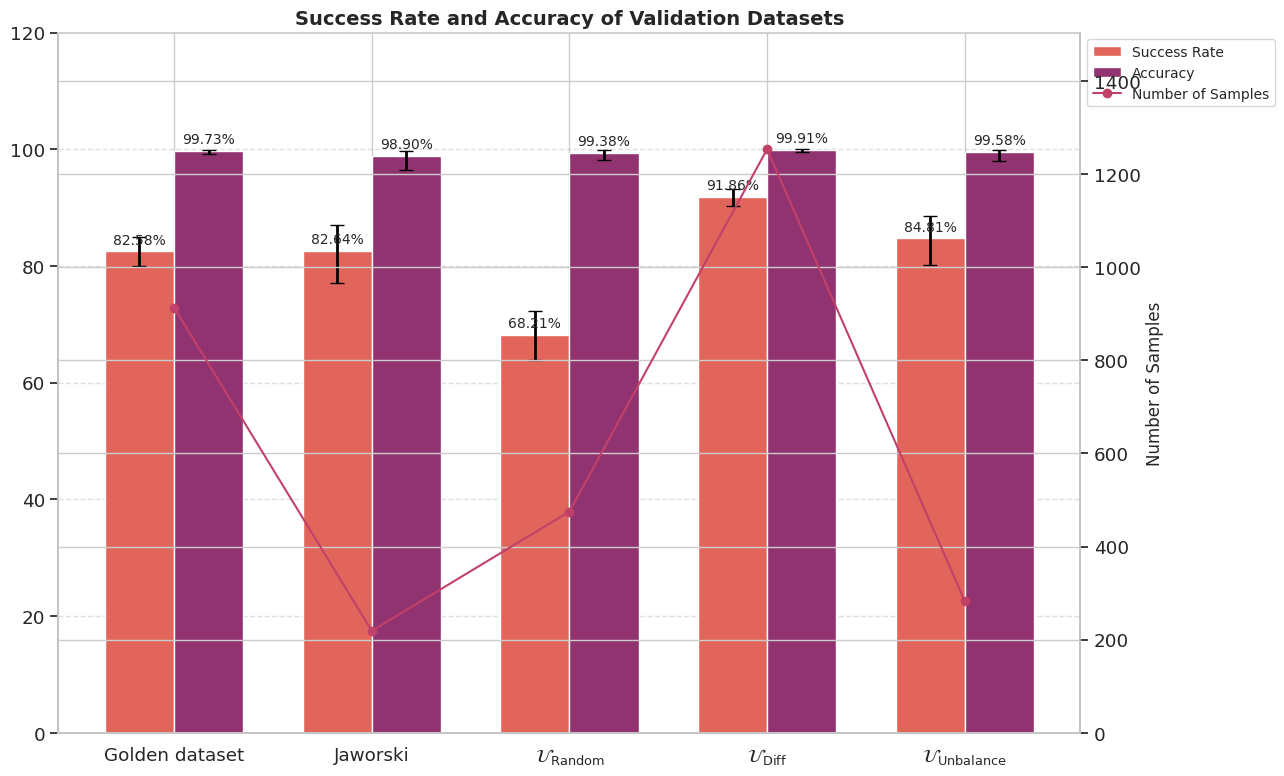

In [272]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

def add_error_bars(values, sample_sizes):
    """Calculate and return the confidence intervals."""
    lower_bounds, upper_bounds = proportion_confint(values * sample_sizes, sample_sizes, method='wilson')
    errors = [values - lower_bounds, upper_bounds - values]  # lower and upper errors
    return errors

# Data
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportion
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportion
unbalance = [913, 219, 475, 1253, 283]
sample_sizes = np.array(unbalance)  # Assuming 'unbalance' is the sample size
sample_sizes_success = np.array(unbalance)
# Error calculations
success_rate_errors = add_error_bars(success_rate, sample_sizes)
accuracy_errors = add_error_bars(accuracy, sample_sizes)

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 8))
ax2 = ax.twinx()

# Using the "flare" colormap
cmap = plt.get_cmap('flare')
color_for_success_rate = cmap(0.3)
color_for_accuracy = cmap(0.7)
color_for_unbalance = cmap(0.5)

# Plotting bars with error bars
bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=np.array(success_rate_errors)*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=np.array(accuracy_errors)*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})

# Line plot for number of samples
bars3 = ax2.plot(index, unbalance, label='Number of Samples', color=color_for_unbalance, marker='o')

plt.ylabel('Percentage (%)', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 120)
ax2.set_ylim(0, max(unbalance) * 1.2)

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.savefig('rule_based.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


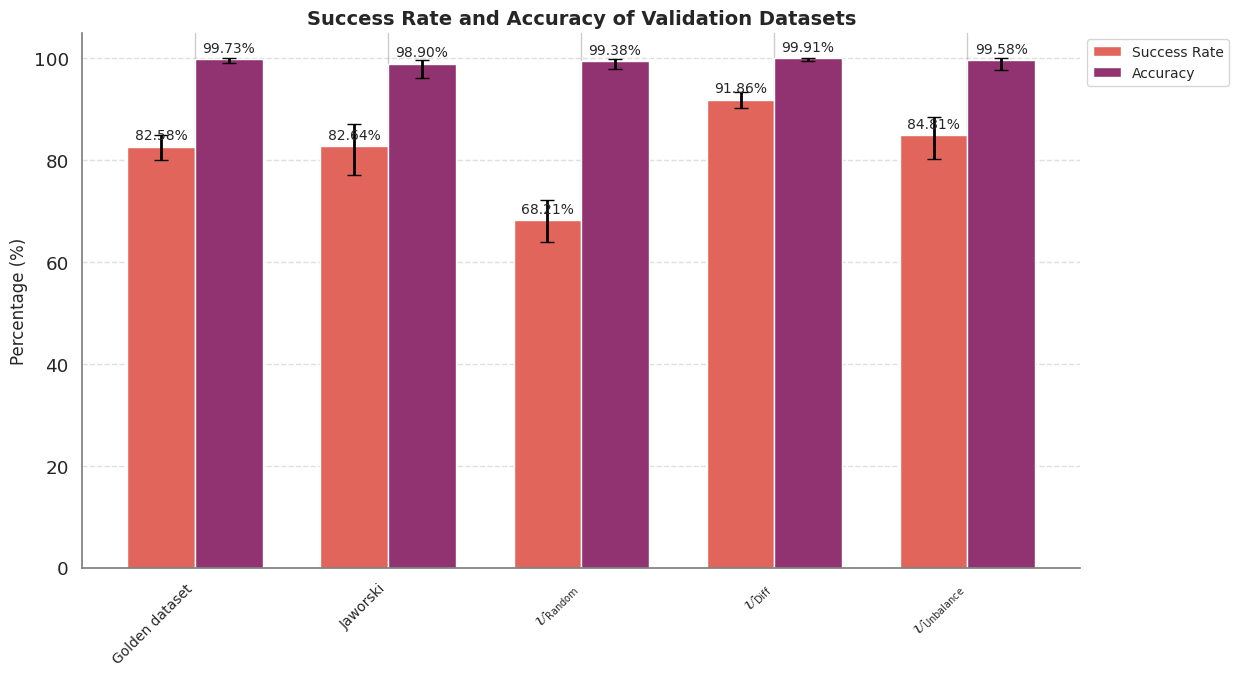

In [273]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Data
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])

# Successes and accuracies
successes = np.round(unbalance * success_rate).astype(int)
accuracies = np.round(successes * accuracy).astype(int)

# Confidence intervals
confint_success = proportion_confint(successes, unbalance, method='wilson')
confint_accuracy = proportion_confint(accuracies, successes, method='wilson')

# Error margins
error_success = np.abs(np.vstack(confint_success) - success_rate)
error_accuracy = np.abs(np.vstack(confint_accuracy) - accuracy)

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 7))

# Colormap
cmap = plt.get_cmap('flare')
color_for_success_rate = cmap(0.3)
color_for_accuracy = cmap(0.7)

# Plotting
bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=error_success*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=error_accuracy*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})

# Labels and styling
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

# Annotation function
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

# Legend and layout
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.savefig('rule_based.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


# analysis MCS

In [ ]:
from SynRBL.SynMCSImputer.SubStructure.mcs_process import ensemble_mcs
from SynRBL.SynUtils.data_utils import load_database, save_database
from SynRBL.SynMCSImputer.SubStructure.extract_common_mcs import ExtractMCS
from SynRBL.SynMCSImputer.MissingGraph.find_graph_dict import find_graph_dict
from SynRBL.SynMCSImputer.MissingGraph.refinement_uncertainty import RefinementUncertainty

mcs1 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_1.json.gz')
mcs2 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_2.json.gz')
mcs3 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_3.json.gz')
mcs4 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_4.json.gz')
mcs5 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_5.json.gz')

In [ ]:
mcs_check_uncertainty('USPTO_unbalance_class')

In [ ]:
data_name = 'golden_dataset'
mcs_dir = f'../../../Data/Validation_set/{data_name}/MCS'
missing_results_largest  = find_graph_dict(msc_dict_path=f'{mcs_dir}/MCS_Largest.json.gz', 
                                            save_path= './test.json.gz')

In [ ]:
datasets = ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble']
golden = [256, 279, 211, 269, 398, 195]
jaworski = [26, 30, 22, 33, 46, 21]
random = [66, 80, 60, 75, 203, 60]
diff = [44, 50, 42, 45, 128, 40]
unbalance = [37, 37, 33, 35, 130, 33]


In [ ]:
# golden
# Uncertainty Data: 256
# STOP HERE Condition_1
# Uncertainty Data: 279
# STOP HERE Condition_2
# Uncertainty Data: 211
# STOP HERE Condition_3
# Uncertainty Data: 269
# STOP HERE Condition_4
# Uncertainty Data: 398
# STOP HERE Condition_5
# Uncertainty Data: 195
# STOP HERE MCS_Largest

# jaworski
# Uncertainty Data: 26
# STOP HERE Condition_1
# Uncertainty Data: 30
# STOP HERE Condition_2
# Uncertainty Data: 22
# STOP HERE Condition_3
# Uncertainty Data: 33
# STOP HERE Condition_4
# Uncertainty Data: 46
# STOP HERE Condition_5
# Uncertainty Data: 21
# STOP HERE MCS_Largest

# random class
#     Uncertainty Data: 66
# STOP HERE Condition_1
# Uncertainty Data: 80
# STOP HERE Condition_2
# Uncertainty Data: 60
# STOP HERE Condition_3
# Uncertainty Data: 75
# STOP HERE Condition_4
# Uncertainty Data: 203
# STOP HERE Condition_5
# Uncertainty Data: 60
# STOP HERE MCS_Largest

# unbalance
# Uncertainty Data: 37
# STOP HERE Condition_1
# Uncertainty Data: 37
# STOP HERE Condition_2
# Uncertainty Data: 33
# STOP HERE Condition_3
# Uncertainty Data: 35
# STOP HERE Condition_4
# Uncertainty Data: 130
# STOP HERE Condition_5
# Uncertainty Data: 33
# STOP HERE MCS_Largest




# diff
# Uncertainty Data: 44
# STOP HERE Condition_1
# Uncertainty Data: 50
# STOP HERE Condition_2
# Uncertainty Data: 42
# STOP HERE Condition_3
# Uncertainty Data: 45
# STOP HERE Condition_4
# Uncertainty Data: 128
# STOP HERE Condition_5
# Uncertainty Data: 40
# STOP HERE MCS_Largest

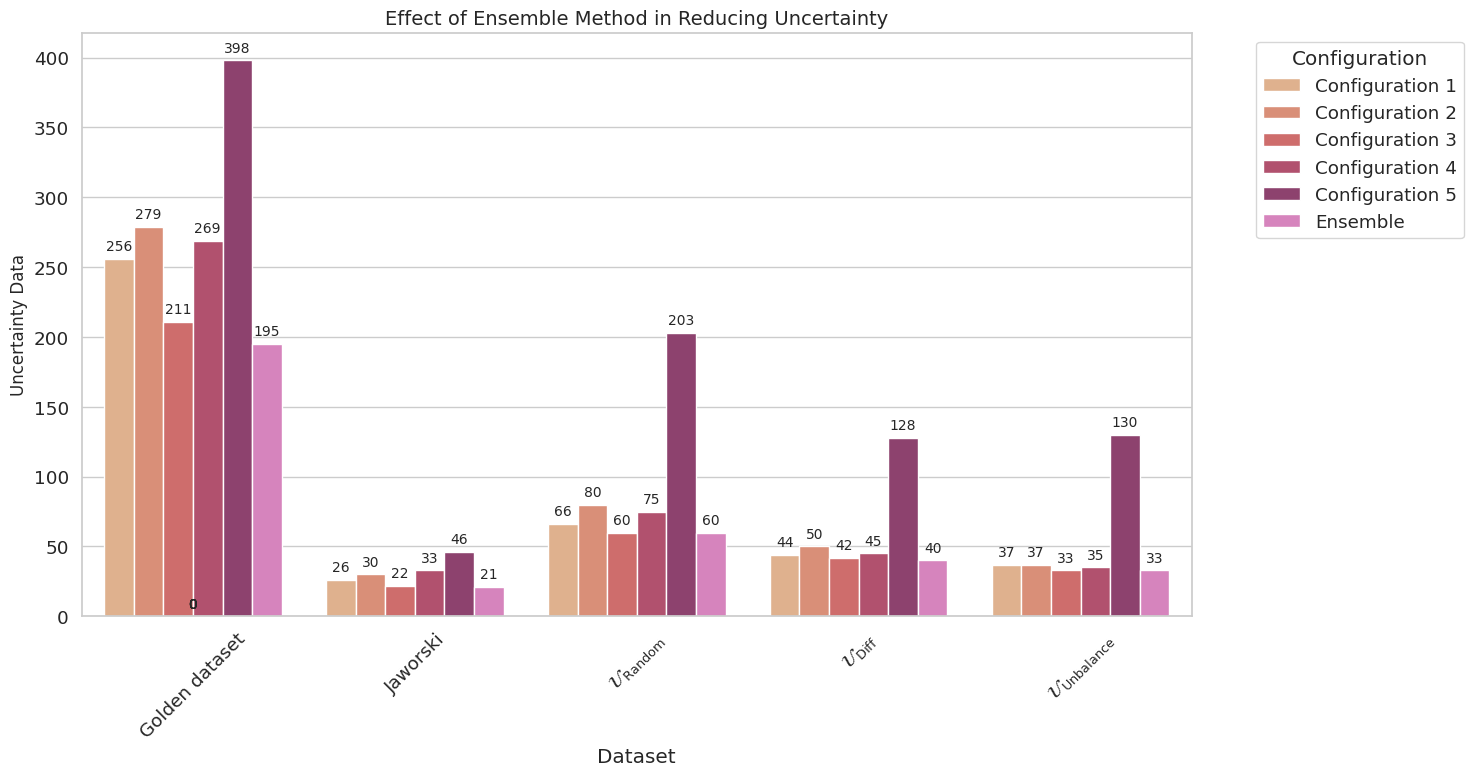

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Plot
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x='Dataset', y='Value', hue='Configuration', data=df, palette=palette)

# Customizing the plot
plt.title('Effect of Ensemble Method in Reducing Uncertainty', fontsize=14)
plt.ylabel('Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate each bar with the value
for p in bar_plot.patches:
    print()
    text = format(p.get_height(), '.0f')
    bar_plot.annotate(text, (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.savefig('./benchmark_mcs.pdf', dpi=300)
plt.show()


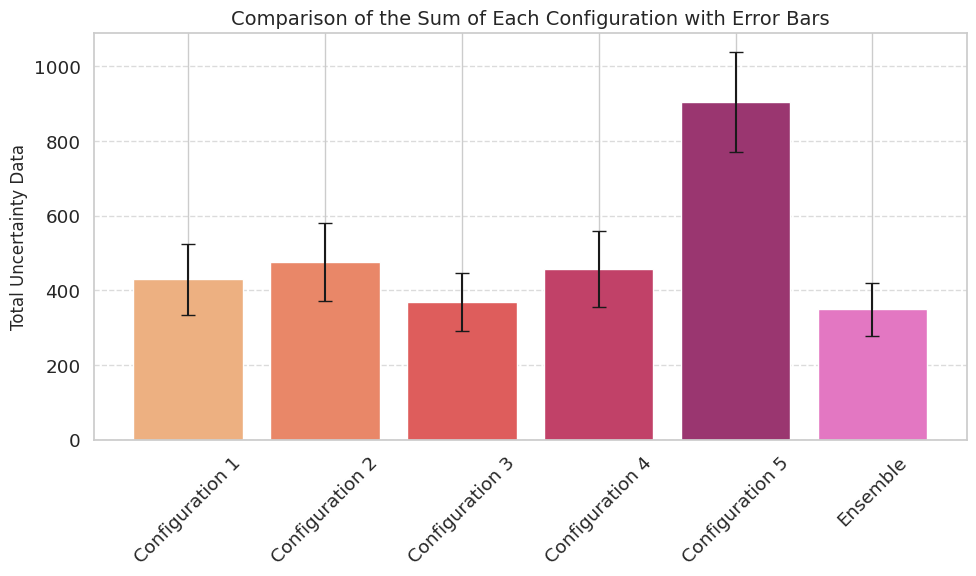

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars
plt.figure(figsize=(10, 6))
plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


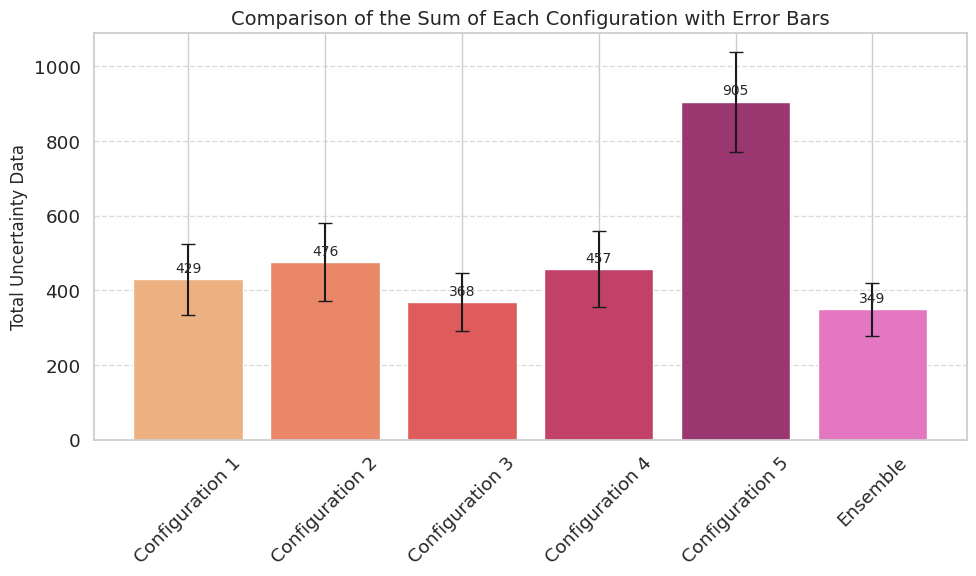

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(10, 6))
bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


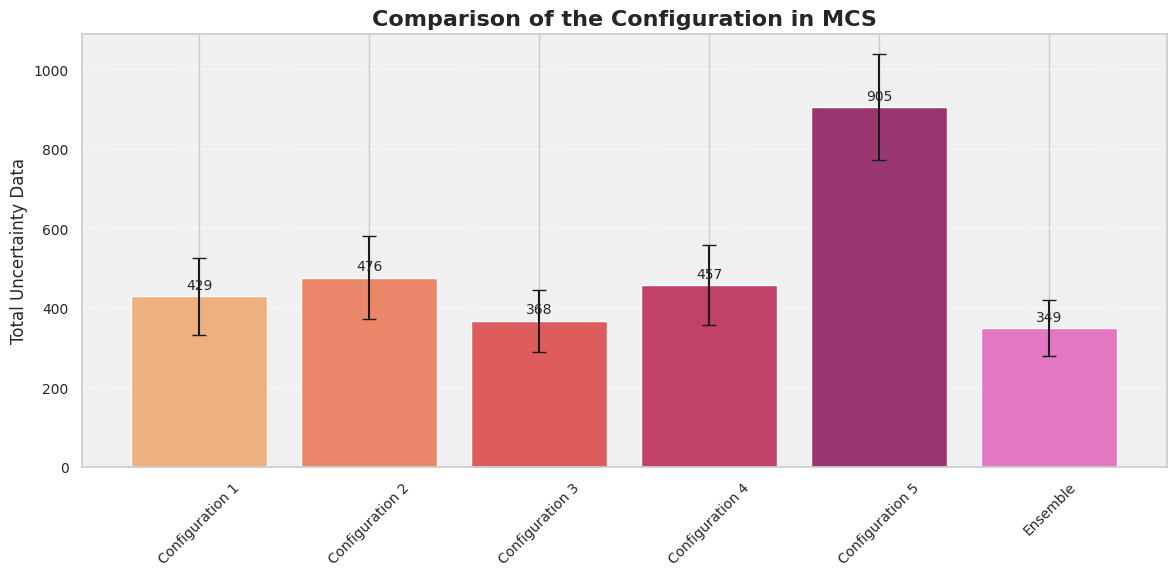

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')  # Adjusted color palette
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(12, 6))

# Adding background color
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Configuration in MCS', fontsize=16, weight='semibold')
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')  # White grid lines for contrast

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [267]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                       "RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                       "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                       "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                       "MCES\nMCES",
                       "Ensemble: Largest"],  # Added "Ensemble: Largest" configuration
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('viridis')  # Adjusted color palette
num_configs = len(df['Configuration'].unique())
palette = [cmap(i / (num_configs - 1)) for i in range(num_configs - 1)]  # Exclude the last color for "Ensemble: Largest"
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette.append(ensemble_color)  # Add the distinct color to "Ensemble: Largest"

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(12, 6))

# Adding background color
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')  # White grid lines for contrast

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Create a custom legend
legend_labels = ["RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                 "RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                 "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                 "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                 "MCES\nMCES",
                 "Ensemble: Largest"]  # Added legend label for "Ensemble: Largest"

legend_colors = [palette[i] for i in range(num_configs)]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colors[i], ec="k", lw=1) for i in range(num_configs)]

plt.legend(legend_handles, legend_labels, title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


ValueError: All arrays must be of the same length